In [17]:
# Cell 1

import os
import csv
import sys
import re
import math
import numpy as np
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

# 멀티스레드 설정(예: 8스레드)
torch.set_num_threads(8)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# Cell 2

# 만약 surprise가 설치되지 않았다면
!pip install scikit-surprise > /dev/null

from surprise import Dataset, Reader

class MovieLens:
    def __init__(self, ratings_path, movies_path):
        self.ratingsPath = ratings_path
        self.moviesPath = movies_path
        self.movieID_to_name = {}
        self.name_to_movieID = {}

    def loadMovieLensLatestSmall(self):
        reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1, rating_scale=(1,5))
        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                movieName = row[1]
                self.movieID_to_name[movieID] = movieName
                self.name_to_movieID[movieName] = movieID

        return ratingsDataset

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = {}
        with open(self.ratingsPath, newline='', encoding='utf-8') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                movieID = int(row[1])
                ratings[movieID] += 1
        # 내림차순 정렬
        rank = 1
        for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
        return rankings

    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[movieID] = genreIDList

        # 비트필드 변환
        for movieID, genreIDList in genres.items():
            bitfield = [0]*maxGenreID
            for g in genreIDList:
                bitfield[g] = 1
            genres[movieID] = bitfield
        return genres

def surprise_dataset_to_list(surprise_dataset):
    """
    Surprise Dataset -> 전체 (user, item, rating) 리스트로 변환
    (build_full_trainset().raw_ratings 대신, surprise_dataset.raw_ratings 사용)
    """
    raw_data = surprise_dataset.raw_ratings
    data_list = []
    for (user, item, rating, _) in raw_data:
        data_list.append((int(user), int(item), float(rating)))
    return data_list

def train_test_split(data_list, test_ratio=0.2, seed=42):
    random.Random(seed).shuffle(data_list)
    cutoff = int(len(data_list)*(1 - test_ratio))
    train_data = data_list[:cutoff]
    test_data = data_list[cutoff:]
    return train_data, test_data

# 예시 경로
ratings_path = "/content/ratings.csv"
movies_path = "/content/movies.csv"

ml = MovieLens(ratings_path, movies_path)
surprise_dataset = ml.loadMovieLensLatestSmall()
data_list = surprise_dataset_to_list(surprise_dataset)
train_data, test_data = train_test_split(data_list, test_ratio=0.2, seed=42)

print("Data Loaded.")
print("Train size:", len(train_data), "Test size:", len(test_data))

Data Loaded.
Train size: 80003 Test size: 20001


In [19]:
# Cell 3

import math
import numpy as np

########################
## 1) 간단히 RMSE, MAE
########################
def rmse(predictions, targets):
    return math.sqrt(np.mean((np.array(predictions) - np.array(targets))**2))

def mae(predictions, targets):
    return np.mean(np.abs(np.array(predictions) - np.array(targets)))

########################
## 2) 아이템 후보군 줄이기
########################
def prune_items_by_popularity(all_items, popularity_ranks, top_k=2000):
    """
    popularity_ranks: 영화ID -> 순위(1이 가장 인기 많음)
    top_k: 상위 몇 개까지 아이템을 사용할지
    """
    # (itemID, rank) 쌍을 rank기준 오름차순 정렬 => rank가 1~top_k 인 아이템 추출
    items_with_rank = [(itm, popularity_ranks.get(itm, 9999999)) for itm in all_items]
    items_with_rank.sort(key=lambda x: x[1])  # rank 오름차순 (1=가장 인기)
    pruned = [x[0] for x in items_with_rank[:top_k]]
    return set(pruned)  # 집합으로 반환

########################
## 3) 한 번만 사용자별 Top-N 추천
########################
def get_topN_for_all_users(model, all_users, candidate_items, user_items_dict, N=10):
    """
    모든 사용자에 대해, (평가 안 한 아이템 중) candidate_items 에 대해서만 예측 → 상위 N
    user_items_dict: u -> (set of rated items)
    """
    user_topN = {}
    for u in all_users:
        rated_items = user_items_dict[u]
        # 후보군 중에서 아직 평가 안 한 아이템
        cands = [i for i in candidate_items if i not in rated_items]
        scores = []
        for i in cands:
            pred = model.predict(u, i)
            scores.append((i, pred))
        scores.sort(key=lambda x: x[1], reverse=True)
        user_topN[u] = [x[0] for x in scores[:N]]
    return user_topN

########################
## 4) Coverage, Diversity, Novelty -> user_topN 이용
########################
def coverage_with_topN(user_topN, all_items):
    recommended = set()
    for u, top_items in user_topN.items():
        for i in top_items:
            recommended.add(i)
    return len(recommended)/len(all_items) if len(all_items)>0 else 0.0

def diversity_with_topN(user_topN, movie_genres):
    """
    user_topN[u] : [item1, item2, ...]
    -> 모든 사용자 topN에 대해 아이템 쌍의 Jaccard Distance 평균
    """
    distances = []
    for u, top_items in user_topN.items():
        if len(top_items)<2:
            continue
        pair_sum = 0.0
        pair_count = 0
        for i1 in range(len(top_items)):
            for i2 in range(i1+1, len(top_items)):
                it1 = top_items[i1]
                it2 = top_items[i2]
                g1 = movie_genres.get(it1, [])
                g2 = movie_genres.get(it2, [])
                if len(g1)==len(g2):
                    inter, union = 0, 0
                    for x,y in zip(g1,g2):
                        if x==1 and y==1:
                            inter+=1
                        if x==1 or y==1:
                            union+=1
                    if union>0:
                        jacc_dist = 1 - (inter/union)
                        pair_sum+= jacc_dist
                        pair_count+=1
        if pair_count>0:
            distances.append(pair_sum/pair_count)
    if len(distances)==0:
        return 0.0
    return float(np.mean(distances))

def novelty_with_topN(user_topN, popularity_ranks):
    """
    user_topN[u]에 포함된 아이템들의 popularity rank 평균
    """
    ranks=[]
    for u, top_items in user_topN.items():
        for i in top_items:
            ranks.append(popularity_ranks.get(i, 9999999))
    if len(ranks)==0:
        return 0.0
    return float(np.mean(ranks))

########################
## 5) HR, cHR, AHAR -> user_topN 이용
########################
def evaluate_topN_metrics(user_topN, test_data, rating_threshold=4.0, N=10):
    """
    user_topN: { user: [topN items] }
    test_data: list of (u,i,r)
    """
    # HR
    hits_hr = 0
    total_hr = 0
    # cHR
    user_hits_count = defaultdict(int)
    user_above_thr = defaultdict(int)
    # AHAR
    # => user가 4점 이상 준 아이템 중 가장 먼저 TopN에 들어오는 아이템 순위
    # => TopN에 없으면 N+1
    # => 평균
    # => 그러나 user_topN[u]에서 해당 아이템이 몇 번째인지 찾아야...
    # 여기선 간단히 rank를 찾으려면 dict { item -> index }

    # user별로 topN -> item->rank 매핑
    user_topN_rank = {}
    for u, items in user_topN.items():
        rank_map = {}
        for rank_idx, it in enumerate(items):
            rank_map[it] = rank_idx+1
        user_topN_rank[u] = rank_map

    sum_ranks = 0
    count_ranks = 0

    for (u, i, r) in test_data:
        if r>=rating_threshold:
            total_hr+=1
            if i in user_topN[u]:
                hits_hr+=1

            user_above_thr[u]+=1
            if i in user_topN_rank[u]:
                # rank
                rank_i = user_topN_rank[u][i]
                user_hits_count[u]+=1
            else:
                # miss
                rank_i = N+1
            sum_ranks += rank_i
            count_ranks +=1

    hr_val = hits_hr/total_hr if total_hr>0 else 0.0
    # cHR
    # 전체 히트 개수 / "4점 이상 준 사용자 수"
    # 하지만 이전 구현에서 cHR = total_hits / total_users
    # total_hits = sum of user_hits_count[u], total_users = # of users with rating >=4
    total_users_chr = sum(1 for u in user_above_thr if user_above_thr[u]>0)
    total_hits_chr = sum(user_hits_count.values())
    chr_val = total_hits_chr / total_users_chr if total_users_chr>0 else 0.0

    # AHAR = average of rank
    ahar_val = sum_ranks/count_ranks if count_ranks>0 else 0.0

    return hr_val, chr_val, ahar_val

In [20]:
# Cell 4

class RBM_PT:
    """
    PyTorch 기반 RBM (소프트맥스 visible)
    mini-batch & GPU
    """
    def __init__(self, num_users, num_items, K=5, F=100, learning_rate=0.01, epochs=10, batch_size=128):
        self.num_users = num_users
        self.num_items = num_items
        self.K = K
        self.F = F
        self.lr = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

        # 파라미터: W, bv, bh
        # W: (num_items, K, F)
        self.W = torch.zeros(num_items, K, F, device=device).normal_(0,0.01)
        self.bv = torch.zeros(num_items, K, device=device)
        self.bh = torch.zeros(F, device=device)

    def _softmax(self, logits):
        max_val, _ = torch.max(logits, dim=-1, keepdim=True)
        ex = torch.exp(logits - max_val)
        return ex / torch.sum(ex, dim=-1, keepdim=True)

    def visible_to_hidden(self, v):
        """
        v: (batch_size, num_items, K) in {0,1}
        return: p(h=1|v), shape (batch_size, F)
        """
        weighted = torch.einsum('bik,ikf->bf', v, self.W) + self.bh
        return torch.sigmoid(weighted)

    def hidden_to_visible(self, h):
        """
        h: (batch_size, F)
        return: softmax over K, shape (batch_size, num_items, K)
        """
        B = h.shape[0]
        W_flat = self.W.view(self.num_items*self.K, self.F).transpose(0,1)
        logits = torch.matmul(h, W_flat)
        logits = logits.view(B, self.num_items, self.K)
        logits = logits + self.bv.unsqueeze(0)
        out = self._softmax(logits)
        return out

    def train(self, train_data):
        user_dict = defaultdict(list)
        for (u,i,r) in train_data:
            user_dict[u].append((i,r))

        user_list = list(user_dict.keys())
        n_users = len(user_list)

        for ep in range(self.epochs):
            random.shuffle(user_list)
            total_cost = 0.0
            for start_idx in range(0, n_users, self.batch_size):
                batch_users = user_list[start_idx:start_idx+self.batch_size]
                B = len(batch_users)

                v_data = torch.zeros(B, self.num_items, self.K, device=device)
                for b_idx, u in enumerate(batch_users):
                    for (i, rating) in user_dict[u]:
                        v_data[b_idx, i, int(rating)-1] = 1.0

                ph = self.visible_to_hidden(v_data)
                h_sample = torch.bernoulli(ph)

                pv_probs = self.hidden_to_visible(h_sample)
                pv = torch.zeros_like(pv_probs)
                for b_idx in range(B):
                    chosen = torch.multinomial(pv_probs[b_idx], 1)
                    pv[b_idx, torch.arange(self.num_items), chosen.squeeze()] = 1.0

                ph_neg = self.visible_to_hidden(pv)

                pos_term = torch.einsum('bik,bf->ikf', v_data, ph)/B
                neg_term = torch.einsum('bik,bf->ikf', pv, ph_neg)/B
                dW = pos_term - neg_term
                self.W += self.lr * dW

                dbv = (v_data.mean(dim=0) - pv.mean(dim=0))
                self.bv += self.lr * dbv
                dbh = (ph.mean(dim=0) - ph_neg.mean(dim=0))
                self.bh += self.lr * dbh

                cost = torch.sum((v_data - pv)**2).item()
                total_cost += cost

            print(f"[Epoch {ep+1}/{self.epochs}] Recon Error: {total_cost:.3f}")

    def predict(self, user, item):
        """
        간단 버전 (user 정보 생략, bias 기반)
        """
        logits = self.bv[item,:]
        probs = self._softmax(logits.unsqueeze(0)).squeeze(0)
        pred = torch.sum(probs*torch.arange(1,self.K+1, device=device, dtype=torch.float))
        return pred.item()

In [21]:
# Cell 5

class ConditionalRBM_PT:
    """
    PyTorch 기반 Conditional RBM
    - rated/unrated 정보를 r: (num_items,)로 받아서 hidden에 추가
    - W: (num_items,K,F)
    - D: (num_items,F)
    """
    def __init__(self, num_users, num_items, K=5, F=100, lr=0.01, epochs=10, batch_size=128):
        self.num_users = num_users
        self.num_items = num_items
        self.K = K
        self.F = F
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.W = torch.randn(num_items, K, F, device=device)*0.01
        self.D = torch.randn(num_items, F, device=device)*0.01
        self.bv = torch.zeros(num_items, K, device=device)
        self.bh = torch.zeros(F, device=device)

    def _softmax(self, x):
        max_x, _ = torch.max(x, dim=-1, keepdim=True)
        ex = torch.exp(x - max_x)
        return ex / torch.sum(ex, dim=-1, keepdim=True)

    def visible_to_hidden(self, v, r):
        weighted = torch.einsum('bik,ikf->bf', v, self.W)
        cond_term = torch.einsum('bi,if->bf', r, self.D)
        return torch.sigmoid(weighted + cond_term + self.bh)

    def hidden_to_visible(self, h, r):
        B = h.shape[0]
        W_flat = self.W.view(self.num_items*self.K, self.F).transpose(0,1)
        logits = torch.matmul(h, W_flat)
        logits = logits.view(B, self.num_items, self.K)
        logits = logits + self.bv.unsqueeze(0)
        out = self._softmax(logits)
        return out

    def train(self, train_data):
        user_dict = defaultdict(list)
        for (u,i,r) in train_data:
            user_dict[u].append((i,r))
        user_list = list(user_dict.keys())
        n_users = len(user_list)

        for ep in range(self.epochs):
            random.shuffle(user_list)
            total_cost = 0.0
            for start_idx in range(0, n_users, self.batch_size):
                batch_users = user_list[start_idx:start_idx+self.batch_size]
                B = len(batch_users)

                v_data = torch.zeros(B, self.num_items, self.K, device=device)
                r_data = torch.zeros(B, self.num_items, device=device)
                for b_idx, u in enumerate(batch_users):
                    for (i, rval) in user_dict[u]:
                        v_data[b_idx, i, int(rval)-1] = 1.0
                        r_data[b_idx, i] = 1.0

                ph = self.visible_to_hidden(v_data, r_data)
                h_sample = torch.bernoulli(ph)

                pv_probs = self.hidden_to_visible(h_sample, r_data)
                pv = torch.zeros_like(pv_probs)
                for b_idx in range(B):
                    chosen = torch.multinomial(pv_probs[b_idx],1)
                    pv[b_idx, torch.arange(self.num_items), chosen.squeeze()] = 1.0

                ph_neg = self.visible_to_hidden(pv, r_data)

                pos_term = torch.einsum('bik,bf->ikf', v_data, ph)/B
                neg_term = torch.einsum('bik,bf->ikf', pv, ph_neg)/B
                dW = pos_term - neg_term
                self.W += self.lr*dW

                # D
                posD = torch.einsum('bi,bf->if', r_data, ph)/B
                negD = torch.einsum('bi,bf->if', r_data, ph_neg)/B
                self.D += self.lr*(posD - negD)

                self.bv += self.lr*(v_data.mean(0) - pv.mean(0))
                self.bh += self.lr*(ph.mean(0) - ph_neg.mean(0))

                cost = torch.sum((v_data - pv)**2).item()
                total_cost += cost

            print(f"[Epoch {ep+1}/{self.epochs}] Recon Error: {total_cost:.3f}")

    def predict(self, user, item):
        logits = self.bv[item,:]
        probs = self._softmax(logits.unsqueeze(0)).squeeze(0)
        pred = torch.sum(probs*torch.arange(1,self.K+1, device=device, dtype=torch.float))
        return pred.item()

In [22]:
# Cell 6

class ConditionalFactoredRBM_PT:
    """
    Conditional Factored RBM
    - W_{i,k,j} = sum_{c=1}^C( A_{i,k,c} * B_{c,j} )
    - D_{i,j}: rated/unrated
    """
    def __init__(self, num_users, num_items, K=5, F=100, C=30, lr=0.01, epochs=10, batch_size=128):
        self.num_users = num_users
        self.num_items = num_items
        self.K = K
        self.F = F
        self.C = C
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.A = torch.randn(num_items, K, C, device=device)*0.01
        self.B = torch.randn(C, F, device=device)*0.01
        self.D = torch.randn(num_items, F, device=device)*0.01

        self.bv = torch.zeros(num_items, K, device=device)
        self.bh = torch.zeros(F, device=device)

    def _softmax(self, x):
        max_x, _ = torch.max(x, dim=-1, keepdim=True)
        ex = torch.exp(x - max_x)
        return ex/torch.sum(ex, dim=-1, keepdim=True)

    def compute_Wik(self):
        """
        A: (I,K,C), B: (C,F)
        => W: (I,K,F)
        """
        W = torch.einsum('ikc,cf->ikf', self.A, self.B)
        return W

    def visible_to_hidden(self, v, r):
        Wfull = self.compute_Wik()  # (I,K,F)
        weighted = torch.einsum('bik,ikf->bf', v, Wfull)
        cond_term = torch.einsum('bi,if->bf', r, self.D)
        return torch.sigmoid(weighted + cond_term + self.bh)

    def hidden_to_visible(self, h, r):
        B = h.shape[0]
        Wfull = self.compute_Wik().view(self.num_items*self.K, self.F).transpose(0,1)
        logits = torch.matmul(h, Wfull)
        logits = logits.view(B, self.num_items, self.K)
        logits = logits + self.bv.unsqueeze(0)
        out = self._softmax(logits)
        return out

    def train(self, train_data):
        user_dict = defaultdict(list)
        for (u,i,r) in train_data:
            user_dict[u].append((i,r))
        user_list = list(user_dict.keys())
        n_users = len(user_list)

        for ep in range(self.epochs):
            random.shuffle(user_list)
            total_cost=0.0
            for start_idx in range(0, n_users, self.batch_size):
                batch_users = user_list[start_idx:start_idx+self.batch_size]
                B = len(batch_users)

                v_data = torch.zeros(B, self.num_items, self.K, device=device)
                r_data = torch.zeros(B, self.num_items, device=device)
                for b_idx, u in enumerate(batch_users):
                    for (i,rval) in user_dict[u]:
                        v_data[b_idx, i, int(rval)-1] = 1.0
                        r_data[b_idx, i] = 1.0

                ph = self.visible_to_hidden(v_data, r_data)
                h_sample = torch.bernoulli(ph)

                pv_probs = self.hidden_to_visible(h_sample, r_data)
                pv = torch.zeros_like(pv_probs)
                for b_idx in range(B):
                    chosen = torch.multinomial(pv_probs[b_idx], 1)
                    pv[b_idx, torch.arange(self.num_items), chosen.squeeze()] = 1.0

                ph_neg = self.visible_to_hidden(pv, r_data)

                # dW
                pos_term = torch.einsum('bik,bf->ikf', v_data, ph)/B
                neg_term = torch.einsum('bik,bf->ikf', pv, ph_neg)/B
                dW = pos_term - neg_term

                # dA, dB
                # dA[i,k,c] = sum_f( dW[i,k,f] * B[c,f] )
                # dB[c,f]   = sum_{i,k}( dW[i,k,f] * A[i,k,c] )
                dA = torch.einsum('ikf,cf->ikc', dW, self.B)
                dB = torch.einsum('ikf,ikc->cf', dW, self.A)

                self.A += self.lr*dA
                self.B += self.lr*dB

                # D
                posD = torch.einsum('bi,bf->if', r_data, ph)/B
                negD = torch.einsum('bi,bf->if', r_data, ph_neg)/B
                self.D += self.lr*(posD - negD)

                self.bv += self.lr*(v_data.mean(0) - pv.mean(0))
                self.bh += self.lr*(ph.mean(0) - ph_neg.mean(0))

                cost = torch.sum((v_data - pv)**2).item()
                total_cost += cost

            print(f"[Epoch {ep+1}/{self.epochs}] Recon Error: {total_cost:.3f}")

    def predict(self, user, item):
        logits = self.bv[item,:]
        probs = self._softmax(logits.unsqueeze(0)).squeeze(0)
        pred = torch.sum(probs*torch.arange(1,self.K+1, device=device, dtype=torch.float))
        return pred.item()

==== (1) RBM ====
[Epoch 1/5] Recon Error: 110058174.000
[Epoch 2/5] Recon Error: 110058165.000
[Epoch 3/5] Recon Error: 110057907.000
[Epoch 4/5] Recon Error: 110057613.000
[Epoch 5/5] Recon Error: 110057442.000

==== (2) Conditional RBM ====
[Epoch 1/5] Recon Error: 110058399.000
[Epoch 2/5] Recon Error: 110057839.000
[Epoch 3/5] Recon Error: 110057442.000
[Epoch 4/5] Recon Error: 110056310.000
[Epoch 5/5] Recon Error: 110055628.000

==== (3) Conditional Factored RBM ====
[Epoch 1/5] Recon Error: 110059666.000
[Epoch 2/5] Recon Error: 110060406.000
[Epoch 3/5] Recon Error: 110058679.000
[Epoch 4/5] Recon Error: 110057809.000
[Epoch 5/5] Recon Error: 110056169.000

===== Evaluate RBM =====

[RBM]
RMSE = 1.1836
MAE  = 0.9673
HR   = 0.0675
cHR  = 1.0817
AHAR = 10.5694
Coverage  = 0.0049
Diversity = 0.8270
Novelty   = 20.6653

===== Evaluate Conditional RBM =====

[ConditionalRBM]
RMSE = 1.1843
MAE  = 0.9678
HR   = 0.0345
cHR  = 0.5532
AHAR = 10.7809
Coverage  = 0.0024
Diversity = 0.8010

<ipython-input-23-956810f6b776>:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(names, rotation=45)
<ipython-input-23-956810f6b776>:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(names, rotation=45)
<ipython-input-23-956810f6b776>:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(names, rotation=45)
<ipython-input-23-956810f6b776>:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(names, rotation=45)
<ipython-input-23-956810f6b776>:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a F

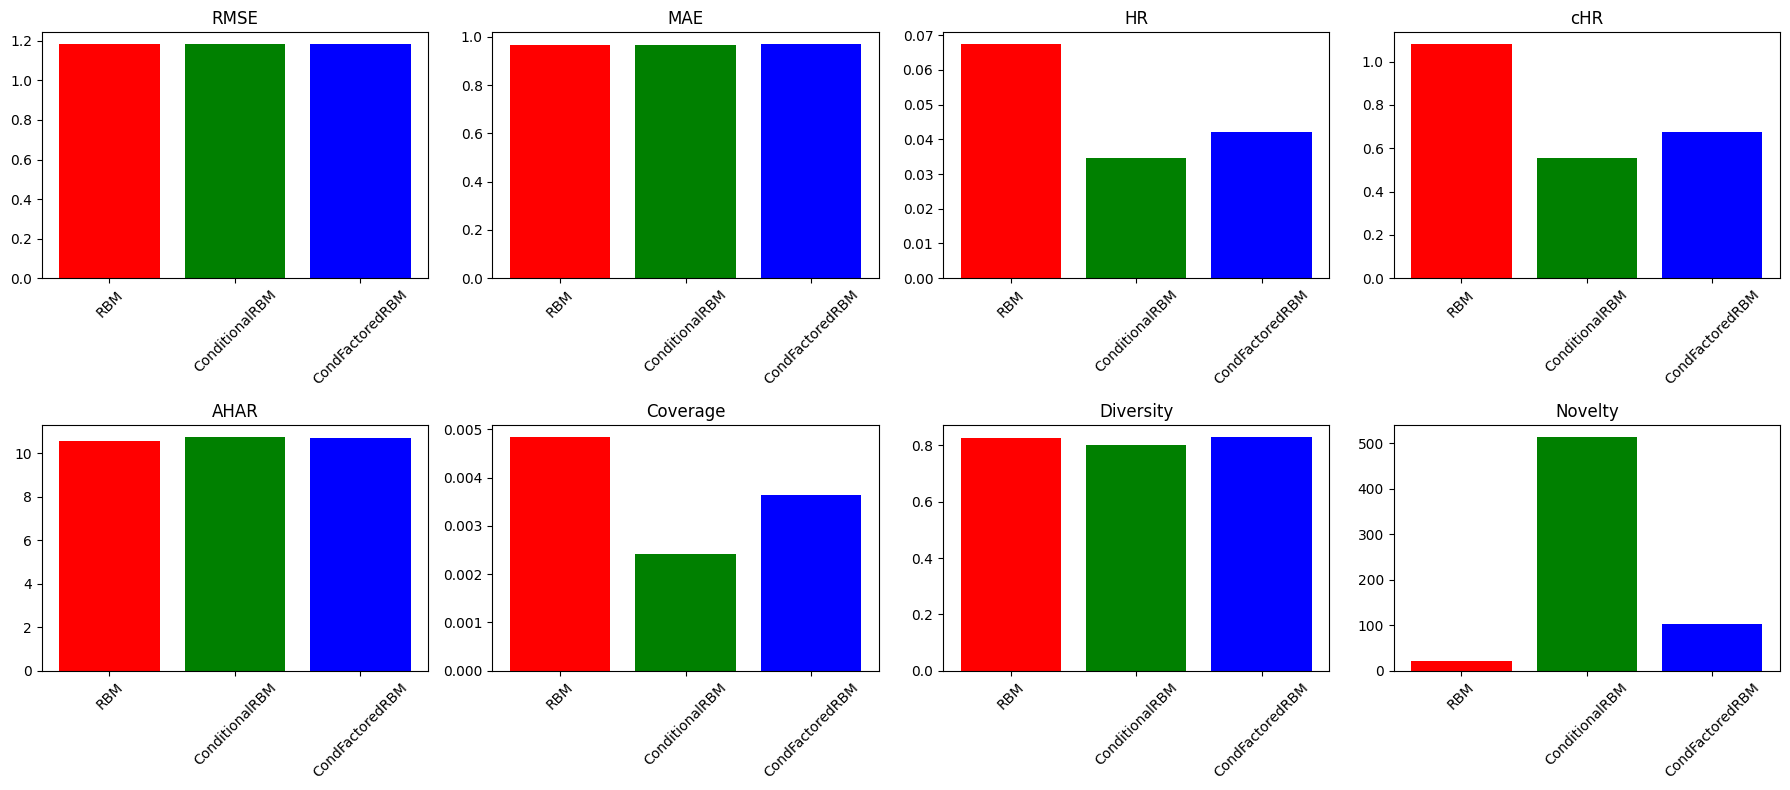

In [23]:
# Cell 7

# 1) 유저/아이템 id 범위 파악
all_users = set([d[0] for d in train_data] + [d[0] for d in test_data])
all_items = set([d[1] for d in train_data] + [d[1] for d in test_data])
num_users = max(all_users) + 1
num_items = max(all_items) + 1

# user -> set of rated items
user_items_dict = defaultdict(set)
for (u,i,r) in train_data:
    user_items_dict[u].add(i)

# 부가 정보
ml_obj = MovieLens(ratings_path, movies_path)
popularity_ranks = ml_obj.getPopularityRanks()
movie_genres = ml_obj.getGenres()

##################################
# (1) 모델들 생성 & 학습
##################################
print("==== (1) RBM ====")
rbm_model = RBM_PT(num_users, num_items, K=5, F=50, learning_rate=0.01, epochs=5, batch_size=128)
rbm_model.train(train_data)

print("\n==== (2) Conditional RBM ====")
crbm_model = ConditionalRBM_PT(num_users, num_items, K=5, F=50, lr=0.01, epochs=5, batch_size=128)
crbm_model.train(train_data)

print("\n==== (3) Conditional Factored RBM ====")
cfrbm_model = ConditionalFactoredRBM_PT(num_users, num_items, K=5, F=50, C=10, lr=0.01, epochs=5, batch_size=128)
cfrbm_model.train(train_data)

##################################
# (2) 평가
##################################
def evaluate_model(model, train_data, test_data, model_name="RBM", top_k_candidates=2000, N=10, rating_threshold=4.0):
    # 1) 예측 정확도 (RMSE, MAE)
    preds, trues = [], []
    for (u,i,r) in test_data:
        pred = model.predict(u,i)
        preds.append(pred)
        trues.append(r)
    rmse_val = rmse(preds, trues)
    mae_val = mae(preds, trues)

    # 2) 아이템 후보군 줄이기
    pruned_items = prune_items_by_popularity(all_items, popularity_ranks, top_k=top_k_candidates)

    # 3) 사용자별 TopN 한 번에 구하기
    user_topN = get_topN_for_all_users(model, all_users, pruned_items, user_items_dict, N=N)

    # 4) HR, cHR, AHAR
    hr_val, chr_val, ahar_val = evaluate_topN_metrics(user_topN, test_data, rating_threshold=rating_threshold, N=N)

    # 5) Coverage, Diversity, Novelty (user_topN 활용)
    coverage_val = coverage_with_topN(user_topN, all_items)
    diversity_val = diversity_with_topN(user_topN, movie_genres)
    novelty_val = novelty_with_topN(user_topN, popularity_ranks)

    # 결과 출력
    print(f"\n[{model_name}]")
    print(f"RMSE = {rmse_val:.4f}")
    print(f"MAE  = {mae_val:.4f}")
    print(f"HR   = {hr_val:.4f}")
    print(f"cHR  = {chr_val:.4f}")
    print(f"AHAR = {ahar_val:.4f}")
    print(f"Coverage  = {coverage_val:.4f}")
    print(f"Diversity = {diversity_val:.4f}")
    print(f"Novelty   = {novelty_val:.4f}")

    return {
        "model": model_name,
        "rmse": rmse_val,
        "mae": mae_val,
        "hr": hr_val,
        "chr": chr_val,
        "ahar": ahar_val,
        "coverage": coverage_val,
        "diversity": diversity_val,
        "novelty": novelty_val
    }

print("\n===== Evaluate RBM =====")
rbm_res  = evaluate_model(rbm_model,  train_data, test_data, "RBM", top_k_candidates=2000, N=10)

print("\n===== Evaluate Conditional RBM =====")
crbm_res = evaluate_model(crbm_model, train_data, test_data, "ConditionalRBM", top_k_candidates=2000, N=10)

print("\n===== Evaluate Conditional Factored RBM =====")
cf_res   = evaluate_model(cfrbm_model,train_data, test_data, "CondFactoredRBM", top_k_candidates=2000, N=10)

# 시각화
results = [rbm_res, crbm_res, cf_res]
metrics = ["rmse","mae","hr","chr","ahar","coverage","diversity","novelty"]
metric_labels = ["RMSE","MAE","HR","cHR","AHAR","Coverage","Diversity","Novelty"]

fig, axs = plt.subplots(2,4,figsize=(18,8))
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    vals = [res[metric] for res in results]
    names= [res["model"] for res in results]
    axs[idx].bar(names, vals, color=["r","g","b"])
    axs[idx].set_title(metric_labels[idx])
    axs[idx].set_xticklabels(names, rotation=45)

plt.tight_layout()
plt.show()